In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload

In [3]:
import numpy as np

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [5]:
import torch
from torch import Tensor

Let's fit a Gaussian distribution using our VB inference engine. <br>
We use the form Sigma = VV^t with V defined as below for the true posterior.<br>
We'll minimize KL[q||p] = <E_p(x)>_q(x) - H(q) w.r.t. q.

In [6]:
import torch.nn as nn

class GaussianEnergy(nn.Module):
    def __init__(self, d):
        super(GaussianEnergy, self).__init__()
        
        U = torch.svd(torch.randn(d,d), some=False).U
        rho = torch.randn(d)
        S = rho.exp()
        V = U*S # cov: VV^T=U S^2 U^T, prec: U S^-2 U^T 
        
        self.register_buffer('_cov', torch.mm(V, V.t()))
        self.register_buffer('sqrtL', U/S)       
        self.register_buffer('mu', torch.randn(d))
        
    def forward(self, x):
        return torch.sum(torch.pow(torch.matmul(self.mu-x,self.sqrtL),2),dim=-1)*.5
    
    def cov(self):
        return self._cov.detach().clone()
    
    def precision(self):
        return torch.mm(self.sqrtL, self.sqrtL.t()) 

In [7]:
from torch.nn.parameter import Parameter
import math

class Foo(nn.Module):
    __constants__ = ['d']
    
    def __init__(self, d):
        super(Foo, self).__init__()
        self.d = d
        self.x = Parameter(torch.Tensor(d))
        self.randomize_parameters()        
        
    def randomize_parameters(self):
        bound = 1 / math.sqrt(self.d)
        nn.init.uniform_(self.x, -bound, bound)   
        
    def forward(self, *input):
        return self.x

In [8]:
def loss(vmodel):
    # Sample models
    models, model_weights = vmodel.sample_model(detach=False)
    
    # -log q
    mlog_q = vmodel.mlog_q()
    
    # Compute energy
    E_p = 0.
    
    for i, model in enumerate(models):            
        # forward and backward the model loss
        model_weight = model_weights[i]
        contribution_model = true_gaussian(model(None)).squeeze()
        E_p += contribution_model*model_weight
    
    #
    H_q = vmodel.entropy_q()
    KL = E_p - mlog_q
    
    return KL, H_q

In [9]:
import dlvi

In [12]:
# True posterior
d = 8
true_gaussian = GaussianEnergy(d)

In [13]:
true_gaussian(true_gaussian.mu)

tensor(0.)

In [14]:
# Our "model"
foo = Foo(d)
print(foo._parameters)

OrderedDict([('x', Parameter containing:
tensor([-0.2773, -0.0659,  0.0219, -0.1486,  0.0751,  0.0395,  0.1845,  0.0821],
       requires_grad=True))])


In [32]:
# Gaussian VB
VPs = dlvi.vp.GaussianVariationalParameters(low_rank_dimension=8, init_zero_mean=True, mode='unscented')

In [33]:
bar = dlvi.Variationalize(lambda: Foo(d), VPs)

In [34]:
bar.state_dict()

OrderedDict([('_x_mean', tensor([0., 0., 0., 0., 0., 0., 0., 0.])),
             ('_x_diag_lstd',
              tensor([-3.8650, -3.8650, -3.8650, -3.8650, -3.8650, -3.8650, -3.8650, -3.8650])),
             ('_x_U',
              tensor([[-0.0548, -0.1550, -0.0741,  0.2690, -0.2472, -0.2834,  0.2136,  0.2122],
                      [-0.0278, -0.1499, -0.0273,  0.0380,  0.1039,  0.1385, -0.1570,  0.1060],
                      [-0.1591, -0.0882,  0.1556, -0.2910, -0.2654, -0.1419,  0.3349,  0.3125],
                      [-0.2364,  0.3015,  0.0924, -0.0622, -0.2368, -0.0323,  0.2607, -0.1075],
                      [ 0.1924, -0.1913,  0.1475,  0.2921, -0.1433,  0.1548, -0.1502,  0.1306],
                      [ 0.3506, -0.0825,  0.2561,  0.0243, -0.1815,  0.2447,  0.2461,  0.3391],
                      [ 0.0127, -0.2032, -0.3152,  0.3277,  0.2639, -0.2881, -0.0298,  0.1238],
                      [-0.2969, -0.2260, -0.1223,  0.0753, -0.1997, -0.2963,  0.2600,  0.0790]])),
            

In [35]:
from torch.optim import Adam

optimizer = Adam(bar.parameters(), lr=1e-1, betas=(0.85, .85))

In [36]:
%%time
epochs = 1000
trace = []
trace_entropy = []

for epoch in range(int(epochs)):
    KL, H_q = loss(bar) 
    
    optimizer.zero_grad()
    KL.backward()
    optimizer.step()
    
    trace.append(KL.item())
    trace_entropy.append(H_q.item())

Wall time: 38.9 s


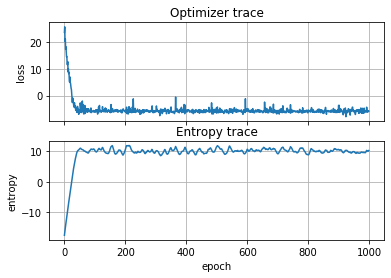

In [37]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

ax1.plot(np.arange(epochs), np.array(trace))
ax1.set(ylabel='loss',
       title='Optimizer trace')
ax1.grid()

ax2.plot(np.arange(epochs), np.array(trace_entropy))
ax2.set(xlabel='epoch', ylabel='entropy',
       title='Entropy trace')
ax2.grid()

plt.show()

Check convergence, compare estimates of mean and covariance to the true ones.

In [38]:
bar.vp_dict

OrderedDict([('globals', None),
             ('locals',
              OrderedDict([('x',
                            GaussianVariationalParameter(mean=Parameter containing:
                            tensor([-2.0385, -1.4008, -1.9277,  1.0407, -1.3514,  1.0884,  1.0780,  0.4256],
                                   requires_grad=True), diag_lstd=Parameter containing:
                            tensor([-0.6208, -0.7140, -0.7301, -0.4825, -1.0852, -2.4544, -0.8349, -4.2246],
                                   requires_grad=True), U=Parameter containing:
                            tensor([[ 0.4636,  2.8735,  4.9931, -2.5318, -4.9330, -4.3735, -2.5257,  4.3752],
                                    [-5.3859, -7.0582,  3.1475,  3.4573, -0.1374,  1.8601, -2.8102, -1.6362],
                                    [-2.7927, -1.9911,  2.9922, -4.2557,  0.8319,  1.7042,  2.4118,  3.6200],
                                    [-1.2627,  0.8121,  0.3726,  0.9250, -5.4727, -0.6705,  1.3516, -2.7653],
 

In [39]:
true_gaussian.mu

tensor([-2.0391, -1.3991, -1.9281,  1.0405, -1.3539,  1.0881,  1.0793,  0.4256])

In [40]:
true_gaussian.cov()

tensor([[ 1.4123, -0.2442,  0.2755,  0.1979,  0.2965, -0.0270, -0.1428, -0.2119],
        [-0.2442,  1.5825, -0.2736,  0.1956,  0.2773, -0.5122, -0.1484,  0.0067],
        [ 0.2755, -0.2736,  1.2885, -0.2429, -0.3407, -0.5106, -0.3263,  0.3870],
        [ 0.1979,  0.1956, -0.2429,  1.1336,  0.1850,  0.3716, -0.2200,  0.4785],
        [ 0.2965,  0.2773, -0.3407,  0.1850,  0.5118,  0.0123,  0.2322, -0.0845],
        [-0.0270, -0.5122, -0.5106,  0.3716,  0.0123,  0.8542, -0.0465, -0.0618],
        [-0.1428, -0.1484, -0.3263, -0.2200,  0.2322, -0.0465,  1.2090,  0.2704],
        [-0.2119,  0.0067,  0.3870,  0.4785, -0.0845, -0.0618,  0.2704,  1.2318]])

In [41]:
vp = bar.vp_list[0]

vp_U = vp.U
norm_U = torch.sqrt(torch.sum(torch.pow(vp_U, 2), dim=list(range(vp_U.dim()-1))) + 1e-3)
V = vp_U * (torch.exp(vp.rho) / norm_U)

C_e = torch.diag(torch.exp(vp.diag_lstd*2)) + torch.matmul(V,V.t())
C_e

tensor([[ 1.5709, -0.3155,  0.3023,  0.1572,  0.3361, -0.0424, -0.2545, -0.2694],
        [-0.3155,  1.8012, -0.3090,  0.2870,  0.2697, -0.6150, -0.2376,  0.0521],
        [ 0.3023, -0.3090,  1.4744, -0.1976, -0.4429, -0.5769, -0.3907,  0.4323],
        [ 0.1572,  0.2870, -0.1976,  1.2295,  0.1521,  0.4025, -0.2067,  0.5412],
        [ 0.3361,  0.2697, -0.4429,  0.1521,  0.5822,  0.0073,  0.2866, -0.0806],
        [-0.0424, -0.6150, -0.5769,  0.4025,  0.0073,  1.0297,  0.0180, -0.0984],
        [-0.2545, -0.2376, -0.3907, -0.2067,  0.2866,  0.0180,  1.1486,  0.3592],
        [-0.2694,  0.0521,  0.4323,  0.5412, -0.0806, -0.0984,  0.3592,  1.4329]],
       grad_fn=<AddBackward0>)

Take a look at eigenvalues of the real and estimated systems.

In [42]:
S = torch.svd(true_gaussian.cov()).S
S

tensor([2.0857, 1.8981, 1.7152, 1.6936, 1.3159, 0.1942, 0.1837, 0.1373])

In [43]:
svd_Ce = torch.svd(C_e)
svd_Ce

torch.return_types.svd(
U=tensor([[-0.4023, -0.0714, -0.3485,  0.5881, -0.4562,  0.2512, -0.3047, -0.0417],
        [ 0.6323,  0.5004, -0.3458,  0.0903, -0.0278,  0.1661, -0.1468, -0.4149],
        [-0.5535,  0.5360,  0.1329, -0.0036,  0.0388, -0.2924,  0.2163, -0.5049],
        [ 0.2410,  0.0189,  0.2553,  0.6730,  0.2087, -0.5902, -0.1311,  0.1199],
        [ 0.1993, -0.1306, -0.1342,  0.1899, -0.4220, -0.1013,  0.8371, -0.0090],
        [ 0.0306, -0.5296,  0.1993,  0.2150,  0.3401,  0.2945,  0.0934, -0.6493],
        [ 0.1653, -0.2199,  0.3437, -0.2680, -0.6474, -0.3192, -0.3263, -0.3269],
        [ 0.0768,  0.3332,  0.7073,  0.1973, -0.1823,  0.5259,  0.0759,  0.1682]],
       grad_fn=<SvdHelperBackward>),
S=tensor([2.3813, 2.2457, 1.9788, 1.8190, 1.3277, 0.2151, 0.1561, 0.1456],
       grad_fn=<SvdHelperBackward>),
V=tensor([[-0.4023, -0.0714, -0.3485,  0.5881, -0.4562,  0.2512, -0.3047, -0.0417],
        [ 0.6323,  0.5004, -0.3458,  0.0903, -0.0278,  0.1661, -0.1468, -0.4149],
  

In [44]:
P_e = torch.mm(svd_Ce.U/svd_Ce.S, svd_Ce.U.t())

In [45]:
C = true_gaussian.cov()
mu = true_gaussian.mu
mu_e = vp.mean

KL = (torch.trace(torch.mm(P_e,C)) + 
        torch.dot(mu_e-mu,torch.mv(P_e,mu_e-mu)) - 
        d +
        torch.sum(torch.log(svd_Ce.S) - torch.log(S))
     ) * 0.5

In [46]:
KL

tensor(0.1211, grad_fn=<MulBackward0>)